In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [34]:
# Load the raw dataset
data = pd.read_csv("C:/Users/shaya/Downloads/shop/new_raw_dataset.csv")


In [36]:
print(data.columns)

Index(['customer_id', 'age', 'gender', 'region', 'product_id', 'category',
       'item_purchased', 'price', 'quantity', 'product_size', 'product_color',
       'purchase_id', 'purchase_date', 'payment_method', 'promo_code_used',
       'shipping_type', 'review_rating', 'is_subscribed',
       'previous_purchases'],
      dtype='object')


In [37]:
# Convert purchase_date to datetime
if 'purchase_date' in data.columns:
    data["purchase_date"] = pd.to_datetime(data["purchase_date"], format="%d-%m-%Y", errors='coerce')
    print("Column 'purchase_date' found in the DataFrame.")
else:
    print("Column 'purchase_date' not found in the DataFrame.")

Column 'purchase_date' found in the DataFrame.


In [38]:
# Time-Based Features
data['month'] = data['purchase_date'].dt.month_name()
data['day_of_week'] = data['purchase_date'].dt.day_name()
data['season'] = data['purchase_date'].dt.month % 12 // 3 + 1  # 1: Winter, 2: Spring, 3: Summer, 4: Fall
data['is_weekend'] = data['day_of_week'].isin(['Saturday', 'Sunday']).astype(int)

# Aggregated Metrics
data['total_revenue'] = data['price'] * data['quantity']

# Calculate category sales
category_sales = data.groupby('category')['total_revenue'].sum().reset_index()
category_sales.rename(columns={'total_revenue': 'category_sales'}, inplace=True)
data = data.merge(category_sales, on='category', how='left')

# Customer Lifetime Value
customer_lifetime_value = data.groupby('customer_id')['total_revenue'].sum().reset_index()
customer_lifetime_value.rename(columns={'total_revenue': 'customer_lifetime_value'}, inplace=True)
data = data.merge(customer_lifetime_value, on='customer_id', how='left')

# Purchase Frequency
purchase_frequency = data.groupby('customer_id')['purchase_id'].count().reset_index()
purchase_frequency.rename(columns={'purchase_id': 'purchase_frequency'}, inplace=True)
data = data.merge(purchase_frequency, on='customer_id', how='left')

# Popularity Score based on total purchases and average review rating
popularity_score = data.groupby('item_purchased').agg(
    total_purchases=('quantity', 'sum'),
    total_revenue=('total_revenue', 'sum'),
    average_review_rating=('review_rating', 'mean')
).reset_index()
popularity_score['popularity_score'] = (
    popularity_score['total_purchases'] * 0.5 + 
    popularity_score['total_revenue'] * 0.3 + 
    popularity_score['average_review_rating'] * 0.2
)
data = data.merge(popularity_score[['item_purchased', 'popularity_score']], on='item_purchased', how='left')

# Trend Indicators
threshold = data['popularity_score'].quantile(0.8)
data['trend_flag'] = (data['popularity_score'] >= threshold).astype(int)

# Discount Effectiveness
# Calculate total revenue with and without promo codes
total_revenue_with_promo = data[data['promo_code_used'] == 1].groupby('item_purchased')['total_revenue'].sum().reset_index()
total_revenue_without_promo = data[data['promo_code_used'] == 0].groupby('item_purchased')['total_revenue'].sum().reset_index()

# Merge the two DataFrames
discount_effectiveness = total_revenue_with_promo.merge(total_revenue_without_promo, on='item_purchased', suffixes=('_with', '_without'))
discount_effectiveness['discount_effectiveness'] = discount_effectiveness['total_revenue_with'] - discount_effectiveness['total_revenue_without']
data = data.merge(discount_effectiveness[['item_purchased', 'discount_effectiveness']], on='item_purchased', how='left')

# Behavioral Insights
average_spending = data.groupby('customer_id')['total_revenue'].mean().reset_index()
average_spending.rename(columns={'total_revenue': 'average_spending'}, inplace=True)
data = data.merge(average_spending, on='customer_id', how='left')

# Average Rating per Category
average_rating_per_category = data.groupby('category')['review_rating'].mean().reset_index()
average_rating_per_category.rename(columns={'review_rating': 'average_rating_per_category'}, inplace=True)
data = data.merge(average_rating_per_category, on='category', how='left')

# Promo Code Spending
promo_code_spending = data[data['promo_code_used'] == 1].groupby('customer_id')['total_revenue'].mean().reset_index()
promo_code_spending.rename(columns={'total_revenue': 'promo_code_spending'}, inplace=True)
data = data.merge(promo_code_spending, on='customer_id', how='left')

# Correlations
age_category_preference = data.groupby(['age', 'category']).size().reset_index(name='count')
age_category_preference = age_category_preference.loc[age_category_preference.groupby('age')['count'].idxmax()]
age_category_preference.rename(columns={'category': 'most_purchased_category_by_age'}, inplace=True)
data = data.merge(age_category_preference[['age', 'most_purchased_category_by_age']], on='age', how='left')

gender_category_preference = data.groupby(['gender', 'category']).size().reset_index(name='count')
gender_category_preference = gender_category_preference.loc[gender_category_preference.groupby('gender')['count'].idxmax()]
gender_category_preference.rename(columns={'category': 'most_purchased_category_by_gender'}, inplace=True)
data = data.merge(gender_category_preference[['gender', 'most_purchased_category_by_gender']], on='gender', how='left')

preferred_shipping_type = data.groupby('category')['shipping_type'].agg(lambda x: x.mode()[0]).reset_index()
preferred_shipping_type.rename(columns={'shipping_type': 'preferred_shipping_type'}, inplace=True)
data = data.merge(preferred_shipping_type, on='category', how='left')

# Print the updated dataset
print(data.head())

                            customer_id  age  gender region  \
0  f45ba1af-fa65-4ada-8c04-d5dacef86459   29    Male   East   
1  7ed82471-c0bf-48a3-81c8-50257949a9b5   29   Other  South   
2  6ebfb0a3-6084-45c2-a571-751b0da2548e   44  Female  South   
3  080507e0-5e50-4aef-9d32-acf287bc6797   39   Other  North   
4  78f4d538-93d9-4952-b9e9-794a372c525d   20    Male  North   

                             product_id     category item_purchased   price  \
0  d1bebb81-f1c1-4820-9dff-ddce24c820d0         Toys          under  277.36   
1  9d7150e4-4904-40fa-979f-fbd45426316a  Electronics            the   36.20   
2  08e41a6f-2c01-4e55-82cb-6982fa8d3976   Home Decor         action  112.79   
3  311f6206-9609-411f-ade4-283ed175006c         Toys           grow   61.22   
4  a02c1611-2f4c-499d-82ae-0a63e9261732  Electronics        quality  146.04   

   quantity product_size  ... purchase_frequency popularity_score trend_flag  \
0         5        Small  ...                  1      1135.473000 

In [39]:
print(data.columns)

Index(['customer_id', 'age', 'gender', 'region', 'product_id', 'category',
       'item_purchased', 'price', 'quantity', 'product_size', 'product_color',
       'purchase_id', 'purchase_date', 'payment_method', 'promo_code_used',
       'shipping_type', 'review_rating', 'is_subscribed', 'previous_purchases',
       'month', 'day_of_week', 'season', 'is_weekend', 'total_revenue',
       'category_sales', 'customer_lifetime_value', 'purchase_frequency',
       'popularity_score', 'trend_flag', 'discount_effectiveness',
       'average_spending', 'average_rating_per_category',
       'promo_code_spending', 'most_purchased_category_by_age',
       'most_purchased_category_by_gender', 'preferred_shipping_type'],
      dtype='object')


In [40]:
# Save the updated dataset
processed_file_path = "C:/Users/shaya/Downloads/shop/processed_dataset.csv"
data.to_csv(processed_file_path, index=False)

print(f"Processed dataset saved to {processed_file_path}")

Processed dataset saved to C:/Users/shaya/Downloads/shop/processed_dataset.csv


SALES AND PRODUCT TRENDS

1. What are the top-selling products/categories?

Top-Selling Categories (Total Quantity Sold):
category
Electronics    4021
Apparel        4002
Home Decor     3977
Toys           3956
Books          3921
Name: quantity, dtype: int64


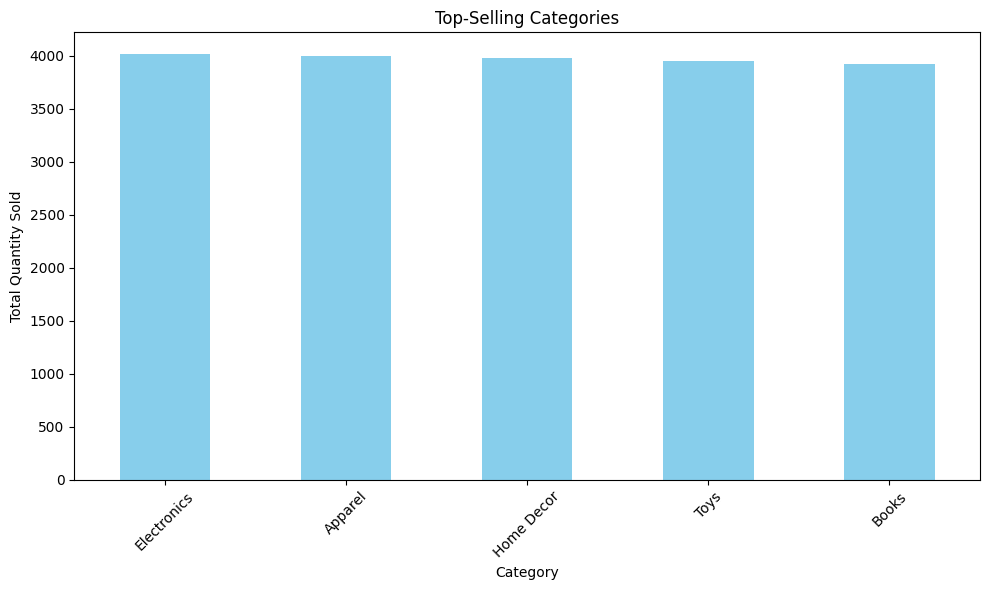

In [5]:
# Load the dataset
data = pd.read_csv("C:/Users/shaya/Downloads/shop/processed_dataset.csv")

# Calculate top-selling categories
top_categories = data.groupby('category')['quantity'].sum().sort_values(ascending=False)

# Print the values
print("Top-Selling Categories (Total Quantity Sold):")
print(top_categories)

# Visualize the results
plt.figure(figsize=(10, 6))
top_categories.plot(kind='bar', color='skyblue')
plt.title('Top-Selling Categories')
plt.xlabel('Category')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

2.	Which product generates the most revenue?

Top Revenue-Generating Products with Categories:
product_id                            category   
950cf83f-2719-4e81-98b0-5f03d8042b39  Books          4491.27
52a4d78c-d0de-4a3e-a729-cae74f494f63  Electronics    4485.06
080be6b7-6ee8-4ce1-995f-cde54029f4e7  Home Decor     4478.13
8b461e0d-1936-4e60-8581-b3dd2f88448d  Toys           4472.10
fe398b5b-11fd-473e-974b-1b8a3768ddfd  Apparel        4471.20
82cf0bfa-cb1e-4429-89dd-37c7165a8e0c  Toys           4468.77
0d2b6729-77d4-47a9-a3f3-608f464640ad  Home Decor     4463.10
f9beb672-06e4-4754-924f-61e4de23055a  Electronics    4461.66
76d796fd-b123-4cd1-8d1d-5274cbadd00e  Toys           4439.43
7f42744b-125f-4ebb-92ab-53d3cbaa8863  Apparel        4436.19
Name: total_revenue, dtype: float64


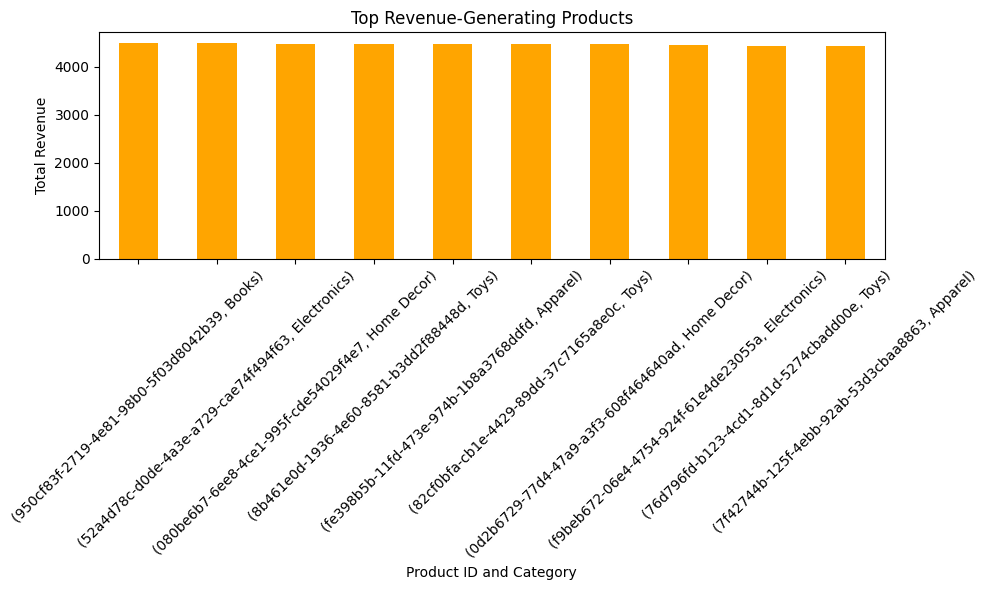

In [6]:
# Calculate top revenue-generating products
top_products_revenue = data.groupby(['product_id', 'category'])['total_revenue'].sum().sort_values(ascending=False)

# Display the top 10 products with their categories and revenue
print("Top Revenue-Generating Products with Categories:")
top_10_products = top_products_revenue.head(10)
print(top_10_products)

# Visualize the top 10 revenue-generating products
plt.figure(figsize=(10, 6))
top_10_products.plot(kind='bar', color='orange')
plt.title('Top Revenue-Generating Products')
plt.xlabel('Product ID and Category')
plt.ylabel('Total Revenue')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

3.	How do sales vary across time periods (day/week/month)?

Total Revenue by Month:
month
April        448281.18
August       408819.91
December     412032.48
February     381532.39
January      408599.16
July         435528.04
June         406778.37
March        477978.51
May          415905.95
November     415992.59
October      446761.73
September    392940.39
Name: total_revenue, dtype: float64


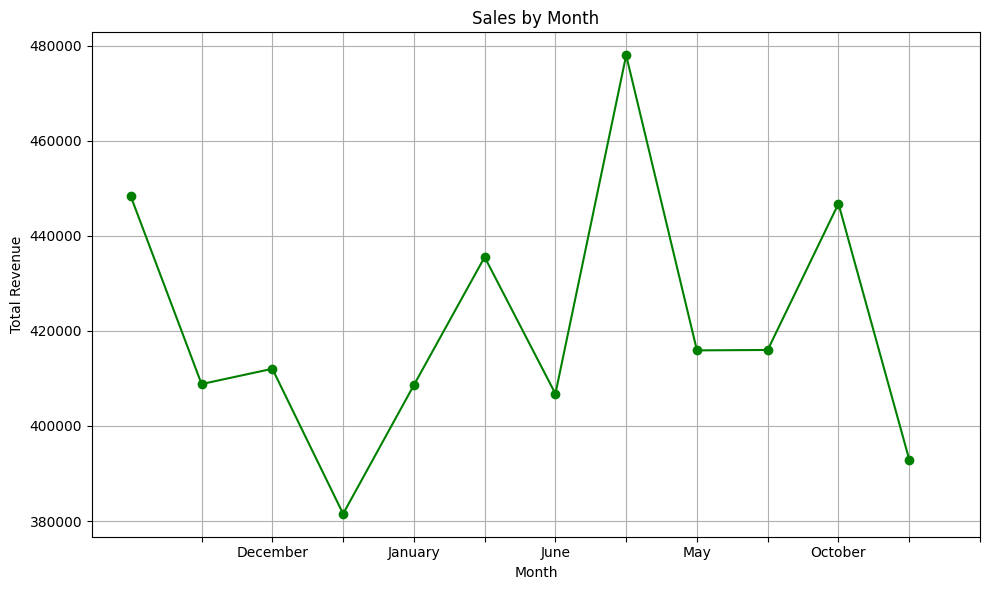

In [8]:
# Group sales by month
sales_by_month = data.groupby('month')['total_revenue'].sum()

# Print the sales values by month
print("Total Revenue by Month:")
print(sales_by_month)
      
# Visualize
plt.figure(figsize=(10, 6))
sales_by_month.plot(kind='line', marker='o', color='green')
plt.title('Sales by Month')
plt.xlabel('Month')
plt.ylabel('Total Revenue')
plt.xticks(range(1, 13))
plt.grid(True)
plt.tight_layout()
plt.show()


4.	Are there specific days of the week with higher sales volumes?

Specific days with higher sales:
day_of_week
Friday       703615.30
Monday       673163.16
Saturday     781078.43
Sunday       752050.60
Thursday     721949.76
Tuesday      742755.26
Wednesday    676538.19
Name: total_revenue, dtype: float64


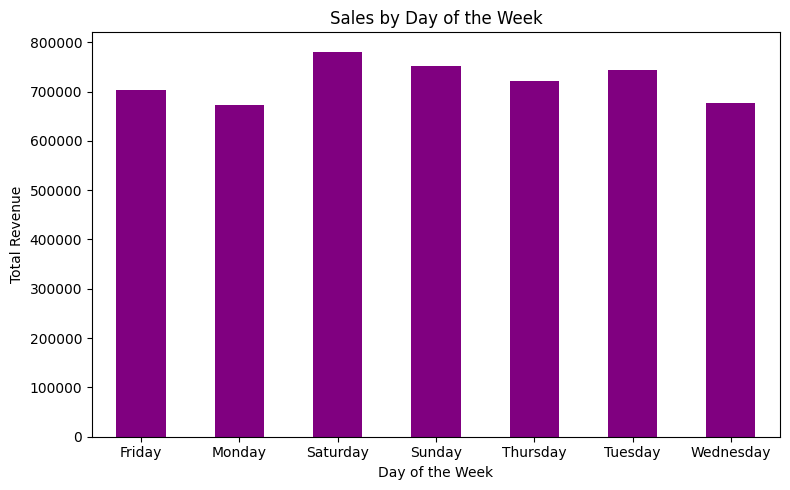

In [9]:
sales_by_day = data.groupby('day_of_week')['total_revenue'].sum()

print("Specific days with higher sales:")
print(sales_by_day)

# Visualize
plt.figure(figsize=(8, 5))
sales_by_day.plot(kind='bar', color='purple')
plt.title('Sales by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Revenue')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


5.	Which products have the highest popularity_score?

Top 5 Products have the highest popularity :
product_id
f4e4086b-a247-4622-af95-44c0fa79e17b    5843.062
69e1a1c2-5cff-4e7f-8d14-90af938ed911    5843.062
addeef63-54d1-4012-b4de-c309153f98b1    5843.062
8b5c5102-7358-466f-a077-b8e81ee4da8f    5843.062
a9320cec-b1b1-43b1-a8bd-de041c10a430    5843.062
Name: popularity_score, dtype: float64


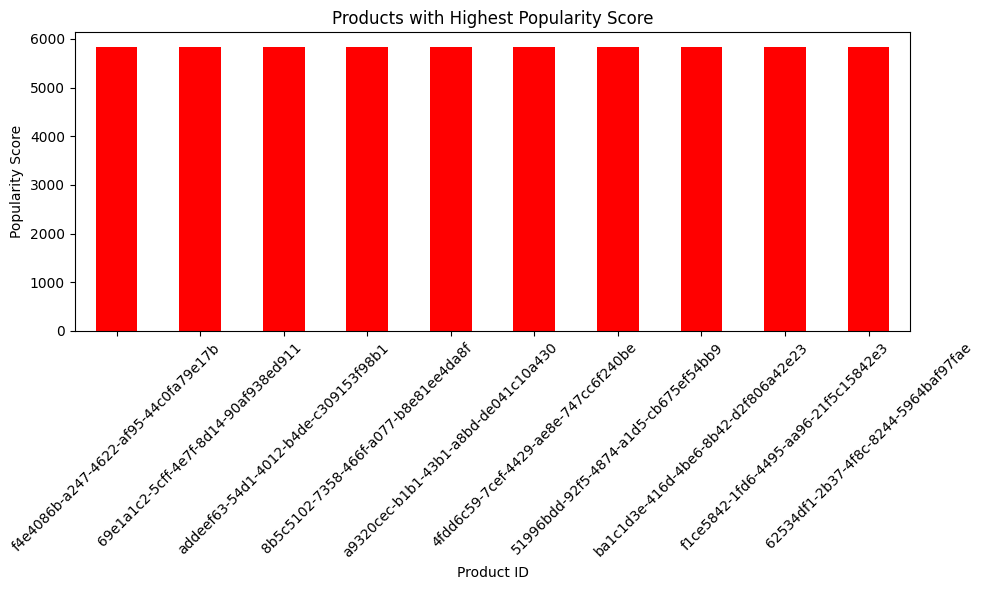

In [12]:
top_popular_products = data.groupby('product_id')['popularity_score'].mean().sort_values(ascending=False)

print("Top 5 Products have the highest popularity :")
top5_popular_products = top_popular_products.head(5)
print(top5_popular_products)

# Visualize
plt.figure(figsize=(10, 6))
top_popular_products.head(10).plot(kind='bar', color='red')
plt.title('Products with Highest Popularity Score')
plt.xlabel('Product ID')
plt.ylabel('Popularity Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


6.	How does total revenue differ across seasons (e.g., summer vs. winter)?

season
1    1202164.03
2    1342165.64
3    1251126.32
4    1255694.71
Name: total_revenue, dtype: float64


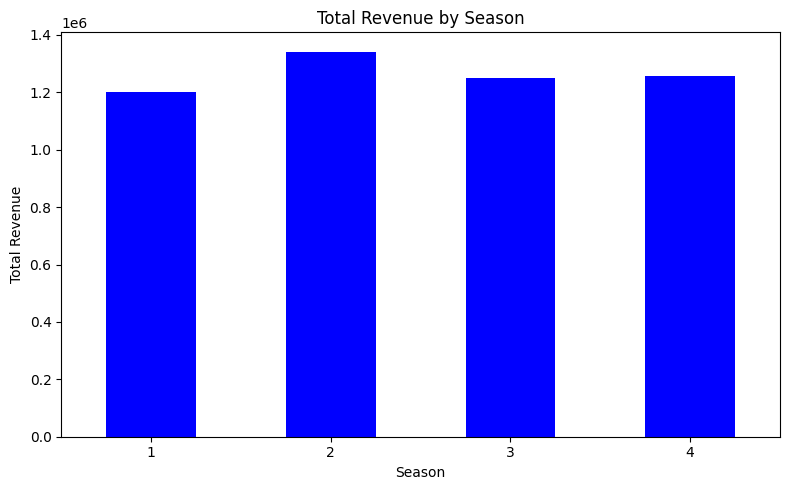

In [13]:
revenue_by_season = data.groupby('season')['total_revenue'].sum()

print(revenue_by_season)

# Visualize
plt.figure(figsize=(8, 5))
revenue_by_season.plot(kind='bar', color='blue')
plt.title('Total Revenue by Season')
plt.xlabel('Season')
plt.ylabel('Total Revenue')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


7.	Are there products/categories with consistent sales trends over time (trend_flag)?

trend_flag      0    1
category              
Apparel      3152  850
Books        3017  904
Electronics  3042  979
Home Decor   3196  781
Toys         2985  971


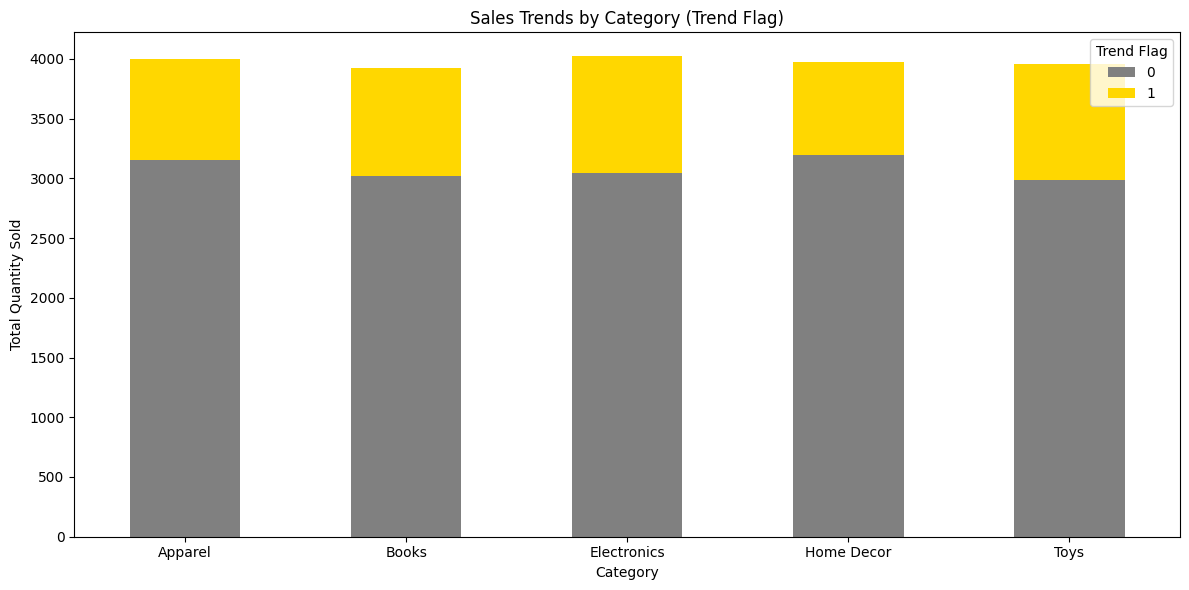

In [18]:
trend_data = data.groupby(['category', 'trend_flag'])['quantity'].sum().unstack()

print(trend_data)

# Visualize
trend_data.plot(kind='bar', stacked=True, figsize=(12, 6), color=['gray', 'gold'])
plt.title('Sales Trends by Category (Trend Flag)')
plt.xlabel('Category')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=0)
plt.legend(title='Trend Flag')
plt.tight_layout()
plt.show()


8.	What is the sales distribution across different product sizes and colors?

product_color  Black  Blue  Green   Red  White
product_size                                  
Large           1450  1376   1249  1443   1255
Medium          1348  1189   1337  1245   1301
Small           1231  1349   1483  1241   1380


<Figure size 1000x600 with 0 Axes>

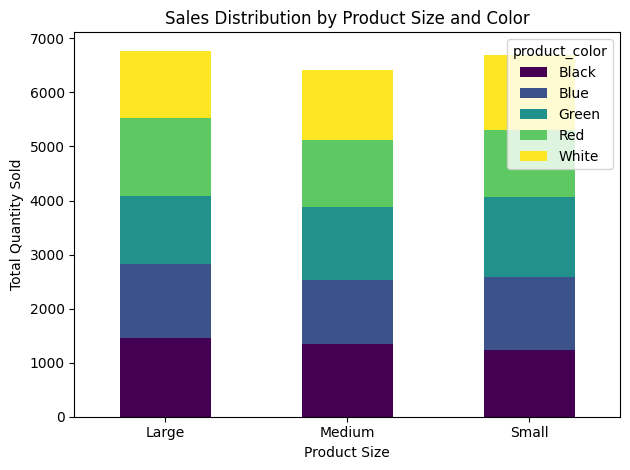

In [17]:
sales_by_size_color = data.groupby(['product_size', 'product_color'])['quantity'].sum().unstack()

print(sales_by_size_color)

# Visualize
plt.figure(figsize=(10, 6))
sales_by_size_color.plot(kind='bar', stacked=True, colormap='viridis')
plt.title('Sales Distribution by Product Size and Color')
plt.xlabel('Product Size')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


9.	How effective are discounts at increasing product sales (discount_effectiveness)?

Total Quantity Sold by Discount Effectiveness:
discount_effectiveness
-12680.63    47
-11914.05    42
-11116.43    35
-9798.30     42
-9059.46     61
             ..
 8149.17     29
 8714.44     28
 8817.08     37
 9231.02     44
 11666.28    56
Name: quantity, Length: 728, dtype: int64


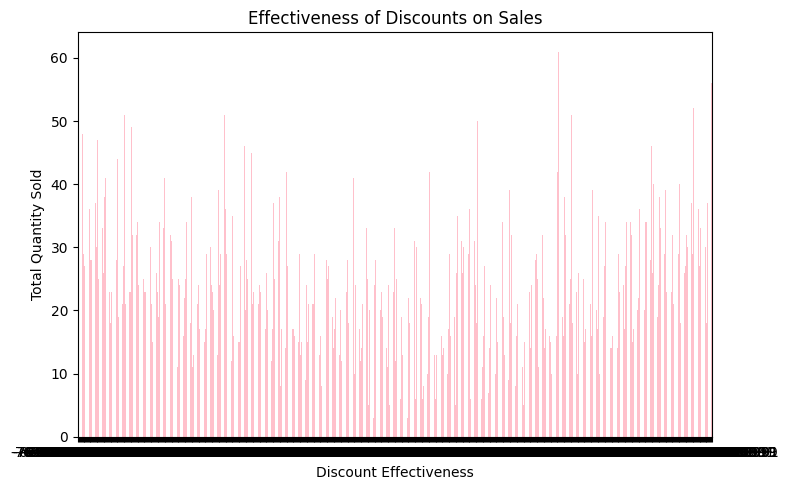


Inference:
The discount effectiveness level '-9059.46' resulted in the highest quantity sold, indicating that this level of discount is particularly effective in driving sales.
On the other hand, the level '79.06' resulted in the lowest quantity sold, suggesting it may be less appealing to customers.


In [20]:
# Group by discount effectiveness and calculate total quantity sold
discount_effectiveness = data.groupby('discount_effectiveness')['quantity'].sum()

# Print the results
print("Total Quantity Sold by Discount Effectiveness:")
print(discount_effectiveness)

# Visualize the results
plt.figure(figsize=(8, 5))
discount_effectiveness.plot(kind='bar', color='pink')
plt.title('Effectiveness of Discounts on Sales')
plt.xlabel('Discount Effectiveness')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Inference
print("\nInference:")
if len(discount_effectiveness) > 1:
    most_effective = discount_effectiveness.idxmax()
    least_effective = discount_effectiveness.idxmin()
    print(f"The discount effectiveness level '{most_effective}' resulted in the highest quantity sold, "
          f"indicating that this level of discount is particularly effective in driving sales.")
    print(f"On the other hand, the level '{least_effective}' resulted in the lowest quantity sold, "
          f"suggesting it may be less appealing to customers.")
else:
    print("All sales are associated with a single level of discount effectiveness, "
          "so there's no comparative inference to draw.")


10.	What are the seasonal bestsellers for specific regions?

region  East  North  South  West
season                          
1       1136   1247   1063  1285
2       1356   1408   1246  1220
3       1192   1282   1189  1281
4       1351   1180   1228  1213


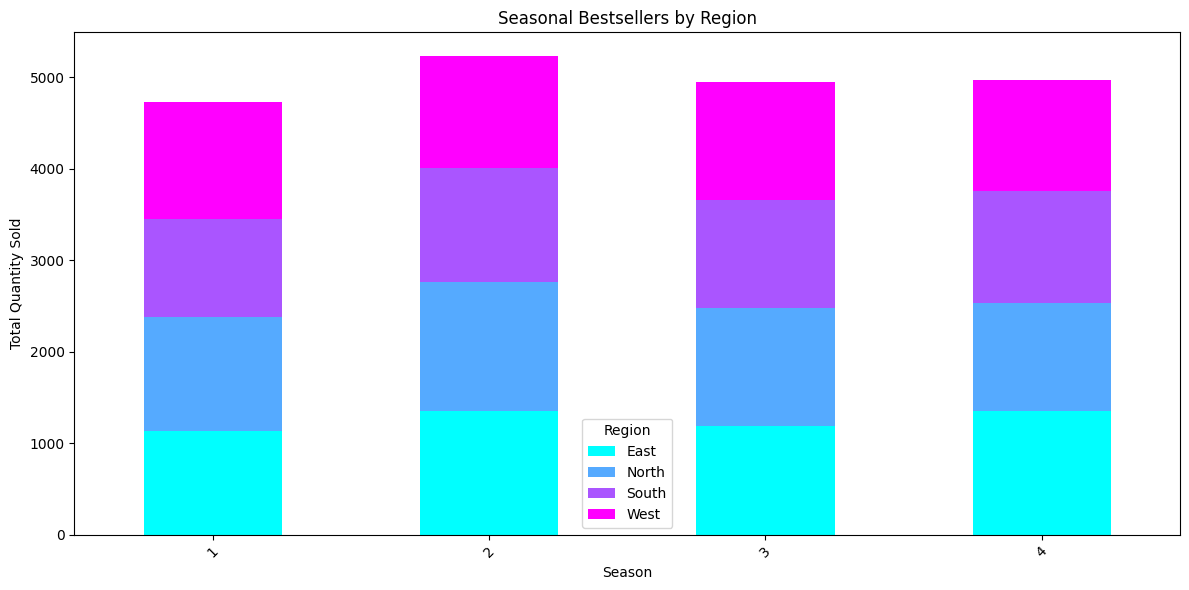

In [22]:
seasonal_bestsellers = data.groupby(['season', 'region'])['quantity'].sum().unstack()

print(seasonal_bestsellers)

# Visualize
seasonal_bestsellers.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='cool')
plt.title('Seasonal Bestsellers by Region')
plt.xlabel('Season')
plt.ylabel('Total Quantity Sold')
plt.xticks(rotation=45)
plt.legend(title='Region')
plt.tight_layout()
plt.show()


In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
import joblib

# Load the dataset
data_path = "C:/Users/shaya/Downloads/shop/processed_dataset.csv"
data = pd.read_csv(data_path)

# Preprocessing function
def preprocess_data(data):
    categorical_cols = ['gender', 'region', 'category', 'product_size', 'product_color',
                        'payment_method', 'shipping_type', 'season', 
                        'most_purchased_category_by_age', 'most_purchased_category_by_gender', 
                        'preferred_shipping_type', 'month', 'day_of_week']
    le = LabelEncoder()
    for col in categorical_cols:
        if col in data.columns:
            data[col] = le.fit_transform(data[col].astype(str))  # Encode strings into integers
    data.fillna(0, inplace=True)  # Fill missing values
    return data

data = preprocess_data(data)

# Define tasks for training models
tasks = {
    "revenue_prediction": {
        "features": ['month', 'day_of_week', 'season', 'category_sales', 'discount_effectiveness'],
        "target": 'total_revenue',
        "model": RandomForestRegressor(),
    },
    "trend_classification": {
        "features": ['month', 'popularity_score', 'category_sales', 'season'],
        "target": 'trend_flag',
        "model": RandomForestClassifier(),
    },
    "discount_effectiveness": {
        "features": ['discount_effectiveness', 'quantity', 'price', 'promo_code_spending'],
        "target": 'discount_effectiveness',
        "model": RandomForestRegressor(),
    },
}

# Train and save models
for task_name, task_details in tasks.items():
    # Extract features and target
    X = data[task_details["features"]]
    y = data[task_details["target"]]

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Train model
    model = task_details["model"]
    model.fit(X_train, y_train)

    # Save model and scaler
    model_filename = f"C:/Users/shaya/Downloads/shop/{task_name}_model.pkl"
    joblib.dump((model, scaler), model_filename)
    print(f"Model saved: {model_filename}")


Model saved: C:/Users/shaya/Downloads/shop/revenue_prediction_model.pkl
Model saved: C:/Users/shaya/Downloads/shop/trend_classification_model.pkl
Model saved: C:/Users/shaya/Downloads/shop/discount_effectiveness_model.pkl
